In [1]:
# Run some setup code for this notebook.

# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from asgn2.cs231n.classifiers.cnn import *
from asgn2.cs231n.data_utils import get_CIFAR10_data
from asgn2.cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from asgn2.cs231n.layers import *
from asgn2.cs231n.fast_layers import *
from asgn2.cs231n.solver import Solver

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
import DataUtils as du
X_train, y_train, P_train, X_val, y_val, P_val, X_test, y_test, P_test = du.loadData()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (18927, 32, 32, 3)
Train labels shape:  (18927,)
Validation data shape:  (5375, 32, 32, 3)
Validation labels shape:  (5375,)
Test data shape:  (2682, 32, 32, 3)
Test labels shape:  (2682,)


In [3]:
import pandas as pd 
df = pd.read_csv(du.images_cooked_train_metadata_filename, sep=',', header=None, names=['label', 'label_name', 'img'])
df['label_name'].value_counts()

dumplings      1091
dal            1031
ramen          1023
icecream       1021
naan           1020
sushi          1020
cordonbleu     1018
pasta          1002
lasagna         971
friedrice       966
roastturkey     930
padthai         919
burger          912
samosa          897
burrito         888
pizza           885
bratwurst       876
biryani         865
sandwich        847
fries           745
Name: label_name, dtype: int64

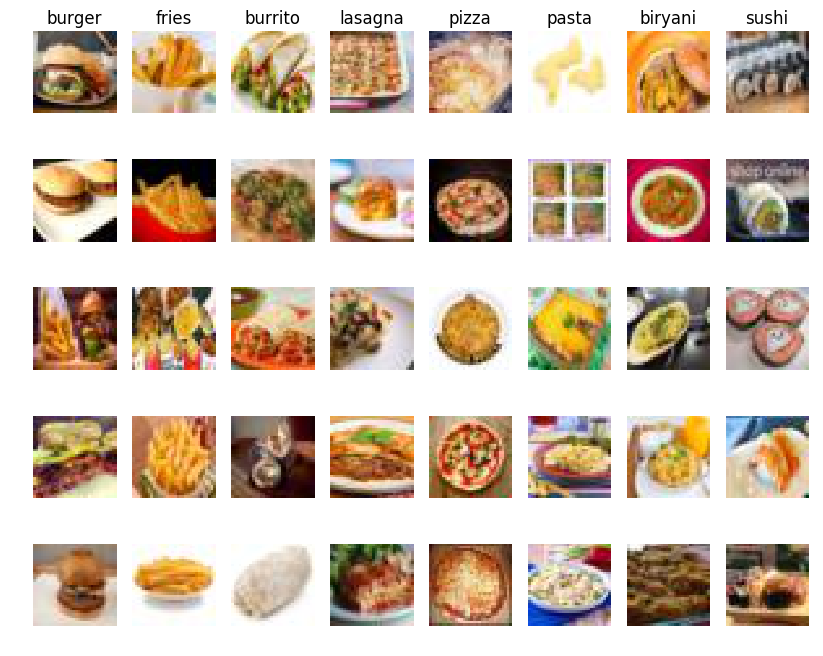

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['burger', 'fries', 'burrito', 'lasagna', 'pizza', 'pasta', 'biryani', 'sushi']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

#plt.savefig('assets/data_vis_2.png')
plt.show()

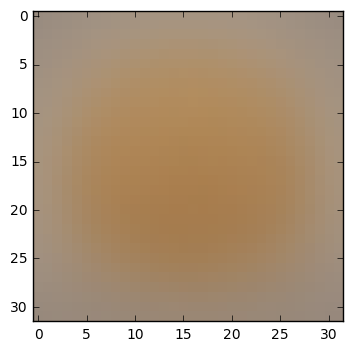

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
#print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.astype('uint8')) # visualize the mean image
plt.show()

In [6]:
mean_image.shape

(32, 32, 3)

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
data = {}
data['X_train'] = X_train.transpose(0,3,1,2)
data['y_train'] = y_train
data['X_val'] = X_val.transpose(0,3,1,2)
data['y_val'] = y_val
data['X_test'] = X_test.transpose(0,3,1,2)
data['y_test'] = y_test

In [9]:
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_test:  (2682, 3, 32, 32)
y_test:  (2682,)
X_train:  (18927, 3, 32, 32)
y_val:  (5375,)
X_val:  (5375, 3, 32, 32)
y_train:  (18927,)


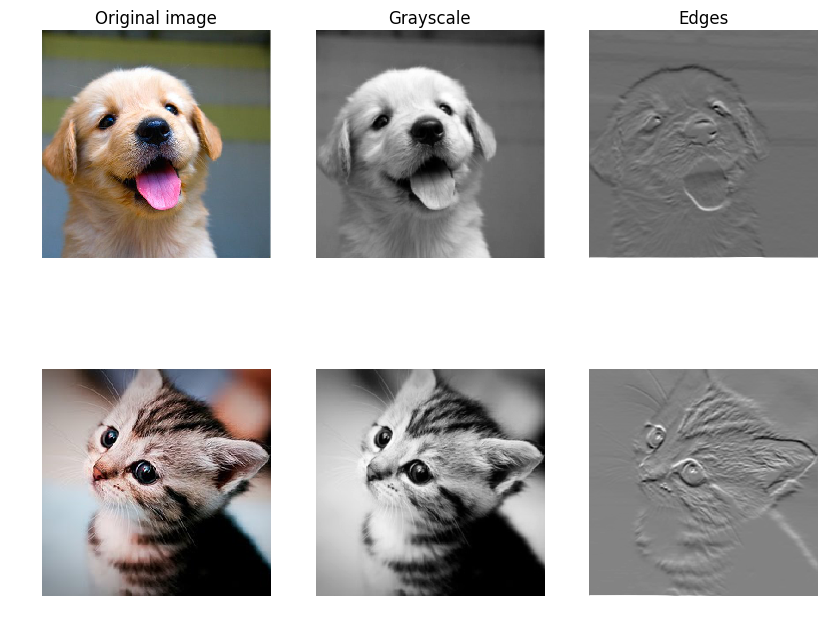

In [10]:
from scipy.misc import imread, imresize

kitten, puppy = imread('assets/kitten.jpg'), imread('assets/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

In [11]:
out.shape

(2, 2, 200, 200)

# Fast layers

In [12]:
model = ThreeLayerConvNet(num_classes=20)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(20, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.99573229036
Initial loss (with regularization):  3.20211260491


## Overfit small data

In [13]:
num_train = 100
r = np.random.choice(len(data['X_train']), num_train, replace=False)
print(r)
small_data = {
  'X_train': data['X_train'][r],
  'y_train': data['y_train'][r],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

[15779 12841  2540  5358 10672 16614 17375 15092 13052 16513 18678 12491
  8732 13345   305  4364   222 13474  5096 18485  5286 16456 16524  1950
 18309 13284  9407  1360 18525 12689 11522 15309   636 12456 16349  9955
  6499 15354 16036  1189  1272 10935 12512 10483  4882 14882  6097 11089
  2916 13003 16552 14102  9787  8668  4390  8500 10787  4423 15816 17246
  4024 17479  4761  5481  4695  1903 11331  4178 14943  5436 18767 15402
 11192  8582 13575 12496 10560 17038  7149  3043  6692  3451  5432  6781
   312  1625  9320 15572 14259  7955  2221  4622  8662  9270  1002  6201
  4810 10759  5555  1408]


In [14]:
np.random.seed(231)

model = ThreeLayerConvNet(weight_scale=1e-2, num_classes=20)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 3.129226
(Epoch 0 / 15) train acc: 0.090000; val_acc: 0.055442
(Iteration 2 / 30) loss: 4.215501
(Epoch 1 / 15) train acc: 0.100000; val_acc: 0.054884
(Iteration 3 / 30) loss: 2.807486
(Iteration 4 / 30) loss: 3.054389
(Epoch 2 / 15) train acc: 0.160000; val_acc: 0.052465
(Iteration 5 / 30) loss: 2.550174
(Iteration 6 / 30) loss: 2.402430
(Epoch 3 / 15) train acc: 0.290000; val_acc: 0.057674
(Iteration 7 / 30) loss: 2.240334
(Iteration 8 / 30) loss: 2.317486
(Epoch 4 / 15) train acc: 0.420000; val_acc: 0.062326
(Iteration 9 / 30) loss: 1.828520
(Iteration 10 / 30) loss: 2.168559
(Epoch 5 / 15) train acc: 0.430000; val_acc: 0.062884
(Iteration 11 / 30) loss: 1.749611
(Iteration 12 / 30) loss: 1.955010
(Epoch 6 / 15) train acc: 0.550000; val_acc: 0.082419
(Iteration 13 / 30) loss: 1.627806
(Iteration 14 / 30) loss: 1.427258
(Epoch 7 / 15) train acc: 0.710000; val_acc: 0.069395
(Iteration 15 / 30) loss: 1.152530
(Iteration 16 / 30) loss: 0.919226
(Epoch 8 / 15) tr

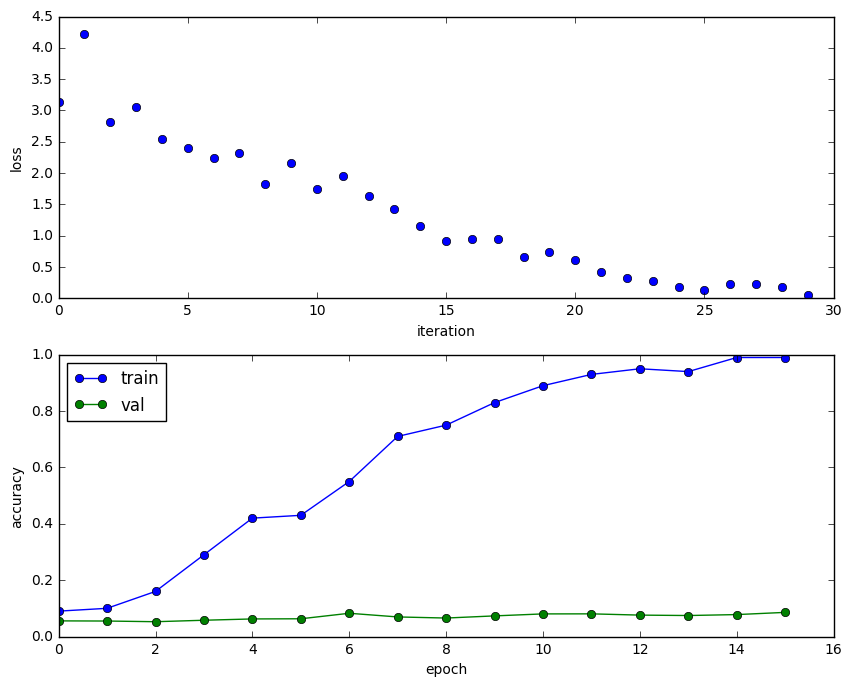

In [15]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [20]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, num_classes=20)

solver = Solver(model, data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 7560) loss: 2.997734
(Epoch 0 / 20) train acc: 0.051000; val_acc: 0.050419
(Iteration 21 / 7560) loss: 2.942083
(Iteration 41 / 7560) loss: 2.986693
(Iteration 61 / 7560) loss: 3.027279
(Iteration 81 / 7560) loss: 2.908056
(Iteration 101 / 7560) loss: 3.014820
(Iteration 121 / 7560) loss: 2.940093
(Iteration 141 / 7560) loss: 2.853791
(Iteration 161 / 7560) loss: 3.134865
(Iteration 181 / 7560) loss: 2.954565
(Iteration 201 / 7560) loss: 2.873216
(Iteration 221 / 7560) loss: 2.896987
(Iteration 241 / 7560) loss: 3.006489
(Iteration 261 / 7560) loss: 2.855850
(Iteration 281 / 7560) loss: 2.778961
(Iteration 301 / 7560) loss: 2.877432
(Iteration 321 / 7560) loss: 2.851279
(Iteration 341 / 7560) loss: 2.892657
(Iteration 361 / 7560) loss: 2.799902
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.113674
(Iteration 381 / 7560) loss: 2.923875
(Iteration 401 / 7560) loss: 2.911423
(Iteration 421 / 7560) loss: 2.684990
(Iteration 441 / 7560) loss: 2.788424
(Iteration 461 / 7560) l

KeyboardInterrupt: 

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Visualize Filters

In [ ]:
from asgn2.cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())